In [80]:
import numpy as np
import pandas as pd
import matplotlib as mtl
import matplotlib.pyplot as plt
import re
from fuzzywuzzy import process as search
from sklearn.preprocessing import MinMaxScaler
from dateutil import parser

## Анализ рынка видеокарт
Для статистического анализа рынка видеокарт собраны следующие данные:
1. techpowerup_gpus_specifications, данные по спецификации для различных моделей видеокарт.
2. tomshardware_gpus_benchmarks, агрегированные данные реалистичного бенчмаркинга производительности 3d рендеринга.
3. kaggle_gpus_benchmarks, данные синтатического бенчмаркинга;
4. userbenchmark_gpus_rating, данные по актуальным ценам и рейтингам видеокарты с агригатора userbenchmark;
4. ~~pcpartpicker_gpus_prices, данные по актуальным ценам на видеокарты с агригатора pcpartpicker~~ (битые данные);
5. ~~pcbuilder_gpus_outdated, данные по ценам за прошлый год с агригатора pcbuilder;~~ (данные с низим уровнем целосности);
6. ~~pcbuilder_gpus_current, данные по ценам за текущий год с агригатора pcbuilder;~~ (данные с низким уровнем целосности);

### Обзор собранных данных
**1. Датасет techpowerup_gpus_specifications**

Источник данных - [techpowerup](https://www.techpowerup.com/gpu-specs/). Способ получения: веб-скраппинг, парсинг. Сайт обладал средним уровнем защиты от веб-скрапинга, для выгрузки данных пришлось использовать программно управляем хромиум (с использованием библиотеки puppeteer).

In [31]:
gpus_specifications = pd.read_json('data/techpowerup_gpus_specifications.json');

print(gpus_specifications.info())
gpus_specifications.drop('url', axis=1).head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713 entries, 0 to 1712
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   manufacturer   1713 non-null   object
 1   model_name     1713 non-null   object
 2   url            1713 non-null   object
 3   chip           1713 non-null   object
 4   release_date   1559 non-null   object
 5   bus_interface  1713 non-null   object
 6   memory_size    1713 non-null   object
 7   memory_type    1713 non-null   object
 8   memory_bus     1713 non-null   object
 9   gpu_clock      1713 non-null   object
 10  memory_clock   1713 non-null   object
dtypes: object(11)
memory usage: 147.3+ KB
None


,manufacturer,model_name,chip,release_date,bus_interface,memory_size,memory_type,memory_bus,gpu_clock,memory_clock
0,ATI,Color Emulation Card,CW16800-A,1986-08-03T20:00:00.000Z,ISA 8-bit,32 KB,DRAM,32 bit,10 MHz,5 MHz
1,ATI,Graphics Solution,CW16800-A,1986-09-21T20:00:00.000Z,ISA 8-bit,64 KB,DRAM,32 bit,10 MHz,5 MHz


Датасет представляет собой набор номинативных признаков для каждой модели видеокарты. В датасете присутствуют следующие поля:
- `manufacturer`, производитель видеокарты;
- `model_name`, модель видеокарты;
- `url`, ссылка на страницу с информацией о видеокарте;
- `chip`, чип видеопроцессора в видеокарты;
- `release_date`, дата выхода на рынок;
- `bus_interface `, используемый тип интерфейса для присоединения к шине материнской платы;
- `memory_size`, объем видеопамяти;
- `memory_type`, тип шины передачи данных видеопамяти;
- `memory_bus`, размер шины передачи данных видеопамяти;
- `gpu_clock`, частота работы видеопроцессора (МГц);
- `memory_clock`, частоты работы видеопамяти (МГц); 

**2. Датасет tomshardware_gpus_benchmarks**

Источник данных - [tomshardware](https://www.tomshardware.com/reviews/gpu-hierarchy,4388.html). Способ получения: веб-скраппинг, парсинг. Сайт обладал низким уровнем защиты от веб-скрапинга, для выгрузки данных хватило загрузки одной страницы. 

In [32]:
gpus_benchmarks = pd.read_json('data/tomshardware_gpus_benchmarks.json');

print(gpus_benchmarks.info())
gpus_benchmarks.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model_name    80 non-null     object 
 1   1080p_ultra   77 non-null     float64
 2   1080p_medium  80 non-null     float64
 3   1440p_ultra   65 non-null     float64
 4   4k_ultra      37 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.2+ KB
None


,model_name,1080p_ultra,1080p_medium,1440p_ultra,4k_ultra
0,GeForce RTX 4090,151.6,189.6,143.1,114.1
1,Radeon RX 7900 XTX,147.5,187.2,133.7,93.0
2,GeForce RTX 4080,142.6,184.4,129.0,88.7
3,Radeon RX 7900 XT,141.2,183.0,124.3,79.6
4,Radeon RX 6950 XT,135.8,187.4,113.7,67.6


Датасет представляет собой набор количественных признаков для выборки из моделей видеокарт.

Остальные параметры датасета - это усредненные значения отрендеренного количества кадров для разных игр, запущенный с определенными настройками:
- 1080p_ultra - самые высокие настройки с разрешением 1080p,
- 1080p_medium - средние с разрешением 1080p,
- 1440p_ultra - самые высокие настройки с разрешением 1440p,
- 4k_ultra - самые высокие настройки с разрешением 4k.

Модель видеокарты характеризуется определенной спецификацией. Т.е. если взять `GeForce RTX 4090`, то в таблице спецификаций можно вытащить номинативные характеристики модели. Пример ниже. 

In [33]:
first_model_name = gpus_benchmarks.iloc[0].get('model_name')
gpus_specifications[gpus_specifications['model_name'] == first_model_name].drop(['url'], axis=1)

,manufacturer,model_name,chip,release_date,bus_interface,memory_size,memory_type,memory_bus,gpu_clock,memory_clock
1031,NVIDIA,GeForce RTX 4090,AD102,2022-09-19T21:00:00.000Z,PCIe 4.0 x16,24 GB,GDDR6X,384 bit,2235 MHz,1313 MHz


Обновляем все имена моделей по спецификации.

In [34]:
gpus_models_in_specs_list = gpus_specifications['model_name'].unique().tolist()
gpus_prices_in_specs_mask = gpus_benchmarks['model_name'].isin(gpus_models_in_specs_list)
gpus_benchmarks_not_in_specs = gpus_benchmarks[~gpus_prices_in_specs_mask]

print(f'found {len(gpus_benchmarks_not_in_specs)} benchmarks not in specifications');

def find_relevant_spec_model(name: str) -> str:
    best_match, score = search.extractOne(name, gpus_models_in_specs_list)
    return best_match

if(len(gpus_benchmarks_not_in_specs)): 
    indexes_to_update = gpus_benchmarks.index[~gpus_prices_in_specs_mask]
    gpus_benchmarks.loc[indexes_to_update, 'model_name'] = np.vectorize(find_relevant_spec_model)(gpus_benchmarks_not_in_specs['model_name'])

found 27 benchmarks not in specifications


**3. Датасет userbenchmark_gpus_rating**

Источник данных - [userbenchmark](https://gpu.userbenchmark.com/). Способ получения: ручной скраппинг, парсинг. Сайт обладал высоким уровнем защиты от веб-скрапинга, в связи с чем пришлось сохранить нужные веб-страницы вручную и после этого распарсить. 

In [35]:
gpus_prices = pd.read_json('data/userbenchmark_gpus_rating.json');

print(gpus_prices.info())
gpus_prices.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   model_name  705 non-null    object
 1   rating      705 non-null    int64 
 2   price       705 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 16.6+ KB
None


,model_name,rating,price
0,RTX 4060,100,300
1,RTX 4060-Ti,98,390
2,RTX 4070-Ti,96,750
3,RTX 3060-Ti,96,440
4,GTX 1660S (Super),95,220


Датасет представлен идентификатором `model_name` и количественными данными: 
- `rating`, отражает лайки пользователей сайта в %;
- `price`, отражает самую низкую цену с Amazon в $; 

Данные по моделям представлены в урезанном формате и требуют выравнивания с данными из датасета со спецификациями.

In [36]:
gpus_prices_in_specs_mask = gpus_prices['model_name'].isin(gpus_models_in_specs_list)
gpus_prices_not_in_specs = gpus_prices[~gpus_prices_in_specs_mask]

print(f'found {len(gpus_prices_not_in_specs)} items not in specifications');

if(len(gpus_prices_not_in_specs)): 
    indexes_to_update = gpus_prices.index[~gpus_prices_in_specs_mask]
    gpus_prices.loc[indexes_to_update, 'model_name'] = np.vectorize(find_relevant_spec_model)(gpus_prices_not_in_specs['model_name'])

found 576 items not in specifications


Пример отображения данных после обработки:

In [37]:
gpus_prices.head()

,model_name,rating,price
0,GeForce RTX 4060,100,300
1,GeForce RTX 4060 Ti 16 GB,98,390
2,GeForce RTX 4070 Ti,96,750
3,GeForce RTX 3060 Ti,96,440
4,GeForce GTX 260 Core 216,95,220


### Статистический анализ

**1. Обзор основных производителей видеокарт по годам**

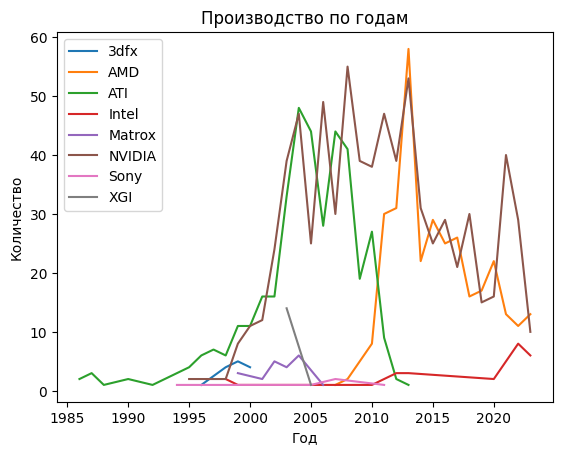

In [38]:
mask_date_is_not_null = ~pd.isnull(gpus_specifications['release_date'])
df = gpus_specifications[mask_date_is_not_null].copy()
df['release_year'] = pd.to_datetime(df['release_date']).dt.year
grouped = df.groupby(['manufacturer'])

for manufacturer in grouped.groups.keys():
    group_by_year = grouped.get_group(manufacturer).groupby(['release_year'])
    
    plt.plot(group_by_year.groups.keys(), group_by_year.size(), label=manufacturer)
    
plt.xlabel('Год')
plt.ylabel('Количество')
plt.title('Производство по годам')
plt.legend()

Судя по графику можно сделать следующие выводы:
- 3dfx, ATI, Matrox, XGI, Sony перестали производить свои видеокарты;
- AMD и NVIDIA являются основными производителями видеокарт на текущий момент; 
- Intel - недавний игрок на рынке видеокарт;
- в 2004 произошел бум в объеме созданных моделей;
- в 2014 году наступила переориентация основных игроков на производство меньшего количества моделей.

In [39]:
df = gpus_specifications[mask_date_is_not_null].copy()
df['release_year'] = pd.to_datetime(df['release_date']).dt.year
year_range_mask = (df['release_year'] < 2010) & (df['release_year'] > 2003)
df_before_2011 = df[year_range_mask & (df['manufacturer'].isin(('ATI', 'NVIDIA')))];
grouped = df_before_2011.groupby(['manufacturer', 'release_year']).size()
grouped.describe()

count    12.000000
mean     39.083333
std      11.090195
min      19.000000
25%      29.500000
50%      42.500000
75%      47.250000
max      55.000000
dtype: float64

С 2003 по 2010 года основные производители видеокарт (NVIDIA, ATI) выпускали в среднем 39 моделей в год. 

In [74]:
df = gpus_specifications[mask_date_is_not_null].copy()
df['release_year'] = pd.to_datetime(df['release_date']).dt.year
year_range_mask = (df['release_year'] >= 2011)
df_after_2011 = df[year_range_mask & (df['manufacturer'].isin(('AMD', 'NVIDIA')))];
grouped = df_after_2011.groupby(['manufacturer', 'release_year']).size()
grouped.describe()

count    26.000000
mean     26.846154
std      12.536961
min      10.000000
25%      16.250000
50%      25.500000
75%      30.750000
max      58.000000
dtype: float64

С 2011 по 2023 года основные производители видеокарт (NVIDIA, AMD) выпускали в среднем 27 моделей в год, что на 30.7% ниже показателя темпа создания новых моделей за 2003-2010 года. 

Можно сделать вывод, что большие игроки на рынке видеокарт будут и дальше снижать разнообразие серийных моделей.

**2. Обзор оценок на видеокарты**

In [115]:
gpus_specifications_clone = gpus_specifications.copy()
gpus_specifications_clone['release_date'] = pd.to_datetime(df['release_date'])
gpus_merged = gpus_prices.merge(gpus_specifications_clone, on='model_name')
gpus_ratings = gpus_merged.drop(['url', 'chip', 'price'], axis=1)
scaler = MinMaxScaler()
gpus_ratings['scaled_rating'] = scaler.fit_transform(gpus_ratings[['rating']])
gpus_ratings.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99])

,rating,scaled_rating
count,761.000000,761.000000
mean,53.541393,0.123423
std,7.127315,0.134478
min,47.000000,0.000000
25%,50.000000,0.056604
50%,52.000000,0.094340
75%,53.000000,0.113208
90%,57.000000,0.188679
99%,92.400000,0.856604
max,100.000000,1.000000


Самая низко оцененная видеокарта имеет 47% пользовательского рейтинга. Больше всего карт оценено в пределах от 50 до 53%. Разброс между картами с самым низким рейтингом и самым высоким колоссальный. Всего 1% видеокарт оценены пользователями высоко (рейтинг 92.4% и более).

In [128]:
latest_gpus = gpus_ratings[gpus_ratings['release_date'].dt.year >= 2010]
q = latest_gpus['scaled_rating'].quantile(0.9)
highly_rated_gpus = latest_gpus[latest_gpus['scaled_rating'] > q]
highly_rated_gpus.head(10)


,model_name,rating,manufacturer,release_date,bus_interface,memory_size,memory_type,memory_bus,gpu_clock,memory_clock,scaled_rating
0,GeForce RTX 4060,100,NVIDIA,2023-05-17 21:00:00+00:00,PCIe 4.0 x8,8 GB,GDDR6,128 bit,1830 MHz,2125 MHz,1.000000
1,GeForce RTX 4060 Ti 16 GB,98,NVIDIA,2023-05-17 21:00:00+00:00,PCIe 4.0 x8,16 GB,GDDR6,128 bit,2310 MHz,2250 MHz,0.962264
2,GeForce RTX 4070 Ti,96,NVIDIA,2023-01-02 21:00:00+00:00,PCIe 4.0 x16,12 GB,GDDR6X,192 bit,2310 MHz,1313 MHz,0.924528
3,GeForce RTX 3060 Ti,96,NVIDIA,2020-11-30 21:00:00+00:00,PCIe 4.0 x16,8 GB,GDDR6,256 bit,1410 MHz,1750 MHz,0.924528
12,GeForce RTX 3060 12 GB,95,NVIDIA,2021-01-11 21:00:00+00:00,PCIe 4.0 x16,12 GB,GDDR6,192 bit,1320 MHz,1875 MHz,0.905660
13,GeForce RTX 3070,94,NVIDIA,2020-08-31 21:00:00+00:00,PCIe 4.0 x16,8 GB,GDDR6,256 bit,1500 MHz,1750 MHz,0.886792
14,GeForce RTX 4090,93,NVIDIA,2022-09-19 21:00:00+00:00,PCIe 4.0 x16,24 GB,GDDR6X,384 bit,2235 MHz,1313 MHz,0.867925
15,GeForce RTX 3080,92,NVIDIA,2020-08-31 21:00:00+00:00,PCIe 4.0 x16,10 GB,GDDR6X,320 bit,1440 MHz,1188 MHz,0.849057
21,GeForce RTX 2060,87,NVIDIA,2019-01-06 21:00:00+00:00,PCIe 3.0 x16,6 GB,GDDR6,192 bit,1365 MHz,1750 MHz,0.754717
24,GeForce RTX 4070,87,NVIDIA,2023-04-11 21:00:00+00:00,PCIe 4.0 x16,12 GB,GDDR6X,192 bit,1920 MHz,1313 MHz,0.754717


manufacturer
AMD        7
NVIDIA    27
dtype: int64


<Axes: >

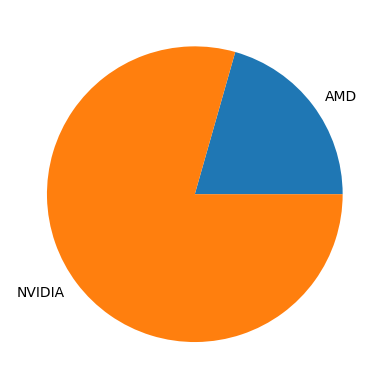

In [134]:
grouped = highly_rated_gpus.groupby('manufacturer').size()
print(grouped)
grouped.plot(kind='pie')

Можно сделать вывод, что пользовательский рейтинг на стороне видеокарт NVIDIA. В топ 10 не представлены другие производители актуальных видеокарт, кроме NVIDIA. Из всего списка представлены только 7 моделей от компании AMD против 27 от компании NVIDIA.  

**3. Обзор самых выгодных видеокарт с точки зрения производительности**

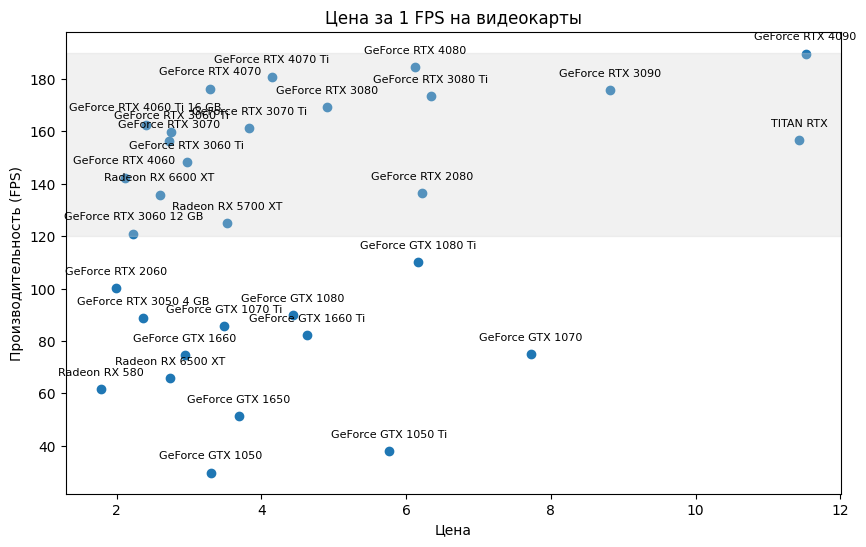

In [179]:
gpus_merged_with_benchmark = gpus_merged.merge(gpus_benchmarks, on='model_name')[['model_name', 'price', '1080p_ultra', '1080p_medium', '1440p_ultra', '4k_ultra']]
gpus_merged_with_benchmark = gpus_merged_with_benchmark[gpus_merged_with_benchmark['price'] > 0]

gpus_for_1080p_medium = gpus_merged_with_benchmark[~pd.isnull(gpus_merged_with_benchmark['1080p_medium'])]
gpus_for_1080p_medium = gpus_for_1080p_medium[['model_name', 'price', '1080p_medium']]
gpus_for_1080p_medium['price_for_1_fps'] = gpus_for_1080p_medium['price'] / gpus_for_1080p_medium['1080p_medium']

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(gpus_for_1080p_medium['price_for_1_fps'], gpus_for_1080p_medium['1080p_medium'])

for i in gpus_for_1080p_medium.index:
    ax.annotate(gpus_for_1080p_medium['model_name'][i], (gpus_for_1080p_medium['price_for_1_fps'][i], gpus_for_1080p_medium['1080p_medium'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.xlabel('Цена')
plt.ylabel('Производительность (FPS)')
plt.title('Цена за 1 FPS на видеокарты')
plt.axhspan(120, 190, color='lightgrey', alpha=0.3)

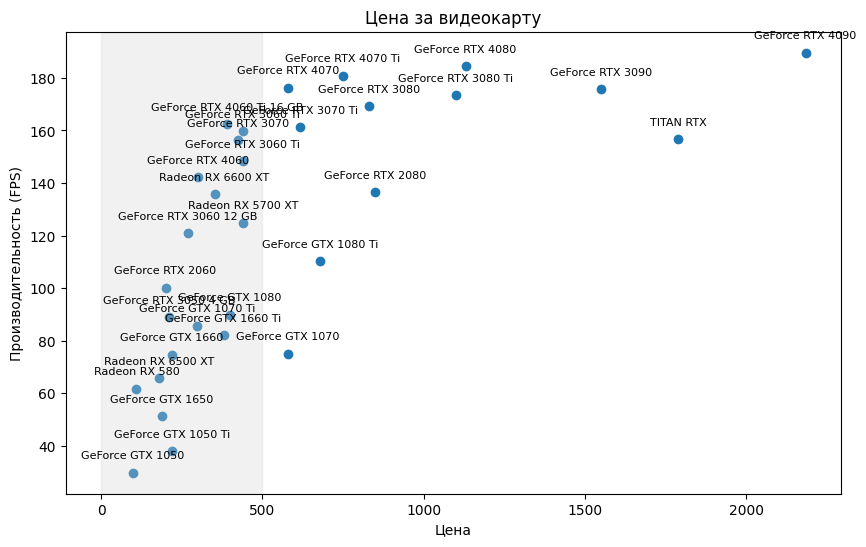

In [176]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(gpus_for_1080p_medium['price'], gpus_for_1080p_medium['1080p_medium'])

for i in gpus_for_1080p_medium.index:
    ax.annotate(gpus_for_1080p_medium['model_name'][i], (gpus_for_1080p_medium['price'][i], gpus_for_1080p_medium['1080p_medium'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.xlabel('Цена')
plt.ylabel('Производительность (FPS)')
plt.title('Цена за видеокарту')
plt.axvspan(0, 500, color='lightgrey', alpha=0.3)


С помощью двух графиков достаточно просто выбрать подходящие видеокарты. График с ценой за FPS отражает выгодность покупки как таковой. Но обычно нужно найти баланс между планируемыми тратами и получаемыми выгодами. Графики демонстрирует производительность на средних настройка и в fullhd. Ценовой диапазон выбран в размере от 0 до 500, а цена за fps показана на графике от 120fps.

Хотелось бы такие же цены на российском рынке. 

### Применение в контексте машинного обучения
- предсказание цен на видеокарты;
- предсказание характеристик и производительности будущих моделей.